In [4]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from math import sqrt
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [5]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [6]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [7]:
# Define the selected exogenous variables and target variable.
features = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]
target = df1['Close']

In [8]:
# Split data into training and testing sets, same ratio applied in SARIMAX.
train_size = int(0.85 * len(features))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Initialize and fit StandardScalers to scale data using Z-score normalization.
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data and transform both training and test data.
X_train_scaled = scaler_X.fit_transform(X_train)  # Fit scaler on training features and transform.
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Fit scaler on training target and transform.

# Transform test data without fitting again to avoid data leakage.
X_test_scaled = scaler_X.transform(X_test)  # Transform test features using the scaler fitted on training data.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))  # Transform test target using the scaler fitted on training data.

# Print minimum and maximum values of the scaled training and test data for verification.
print("Scaled Training Features - Min:", X_train_scaled.min(), "Max:", X_train_scaled.max())
print("Scaled Training Target - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Features - Min:", X_test_scaled.min(), "Max:", X_test_scaled.max())
print("Scaled Test Target - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())


Scaled Training Features - Min: -5.4955652189278625 Max: 9.795796286704956
Scaled Training Target - Min: -3.526234546763028 Max: 2.4845799166596207
Scaled Test Features - Min: -3.5237835824322223 Max: 29.172000533821247
Scaled Test Target - Min: -3.526234546763028 Max: 2.4845799166596207


## Sequence Length = 4 

In [10]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 4  # Number of time steps used for target prediction, 4 weeks.

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (872, 4, 5)
Reshaped y_train_seq shape: (872, 1)
Reshaped X_test_seq shape: (151, 4, 5)
Reshaped  y_test_seq shape: (151, 1)


### Random Parameters. (Model 1)

In [12]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define hyperparameters
dropout_rate = 0.3          # Dropout rate to help prevent overfitting by randomly dropping nodes during training.
l2_lambda = 0.01            # L2 regularization factor, penalizes large weights and attempt to prevent overfitting.
learning_rate = 0.0002      # Learning rate for the optimizer to control how much to adjust weights during backpropagation.
epochs = 50                 # Maximum number of training epochs.
batch_size = 128            # Batch size for each training step, determines how many samples are used in each gradient update.

# Initialize the LSTM model.
model = Sequential()

# First LSTM layer with L2 regularization and dropout.
model.add(LSTM(units=64,                    # Number of LSTM units (neurons) in the layer.
               return_sequences=True,       # Ensures that the layer returns the entire sequence for the next LSTM layer.
               input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape: (sequence length, number of features).
               kernel_regularizer=l2(l2_lambda)))  # Applies L2 regularization to reduce overfitting.
model.add(Dropout(dropout_rate))            # Adds dropout layer to reduce overfitting by randomly setting some neurons to 0.

# Second LSTM layer with L2 regularization and dropout.
model.add(LSTM(units=64,                    # Number of LSTM units in the second layer.
               return_sequences=False,      # Last LSTM layer should not return sequences; it outputs only the final state.
               kernel_regularizer=l2(l2_lambda)))  # L2 regularization to prevent overfitting.
model.add(Dropout(dropout_rate))            # Dropout for regularization.

# Output layer
model.add(Dense(1))                         # Dense layer with a single unit, since its predicting a single value (regression).

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),  # Adam optimizer with a specified learning rate.
              loss='mean_squared_error')                    # Mean Squared Error (MSE) as the loss function for regression.

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',          # Monitor validation loss to stop if it stops improving.
                               patience=10,                 # Wait for 10 epochs with no improvement before stopping.
                               restore_best_weights=True)   # Restore model weights from the epoch with the lowest validation loss.

# Train the model
history = model.fit(X_train_seq, y_train_seq,               # Training data (features and target).
                    epochs=epochs,                          # Maximum number of epochs.
                    batch_size=batch_size,                  # Batch size.
                    validation_data=(X_test_seq, y_test_seq),  # Validation data to monitor overfitting.
                    callbacks=[early_stopping],             # Callback for early stopping. 
                    shuffle=False,
                    verbose=1)                              # Verbose output for progress during training.

# Print final training and validation loss values.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 2.0812 - val_loss: 2.1753
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.0504 - val_loss: 2.1441
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0264 - val_loss: 2.1133
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9954 - val_loss: 2.0839
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9676 - val_loss: 2.0555
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.9344 - val_loss: 2.0277
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9054 - val_loss: 2.0009
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8793 - val_loss: 1.9751
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8576 - val_loss: 1.9500
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8300 - val_loss: 1.9259
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8045 - val_loss: 1.9022
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7882 - val_loss: 1.8792


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Model Performance:
Training RMSE: 0.020287423451894594
Test RMSE: 0.023094093455977842
Training MAE: 0.014687988017215093
Test MAE: 0.01751759367668148
Directional Accuracy on Training Data: 52.81285878300803%
Directional Accuracy on Test Data: 56.666666666666664%


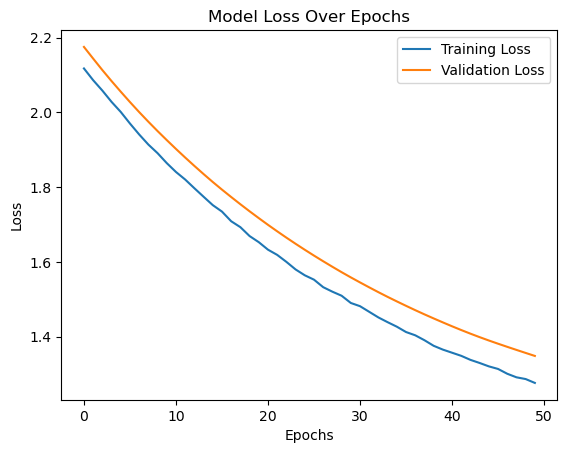

In [13]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2

In [15]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'huber_loss',
    'learning_rate_decay': 1e-6,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 150,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False,
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - loss: 3.5201 - val_loss: 1.4710
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.2621 - val_loss: 1.4693
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2747 - val_loss: 1.4705
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.0766 - val_loss: 1.4693
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.9527 - val_loss: 1.4722
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7489 - val_loss: 1.4685
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.7299 - val_loss: 1.4684
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.7223 - val_loss: 1.4653
Epoch 9/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.6674 - val_loss: 1.4577
Epoch 10/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.5854 - val_loss: 1.4552
Epoch 11/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.4373 - val_loss: 1.4539
Epoch 12/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM Model Performance:
Training RMSE: 0.0201052013947683
Test RMSE: 0.022911279502954792
Training MAE: 0.014736304543750413
Test MAE: 0.017639764639251702
Directional Accuracy on Training Data: 55.683122847301945%
Directional Accuracy on Test Data: 51.33333333333333%


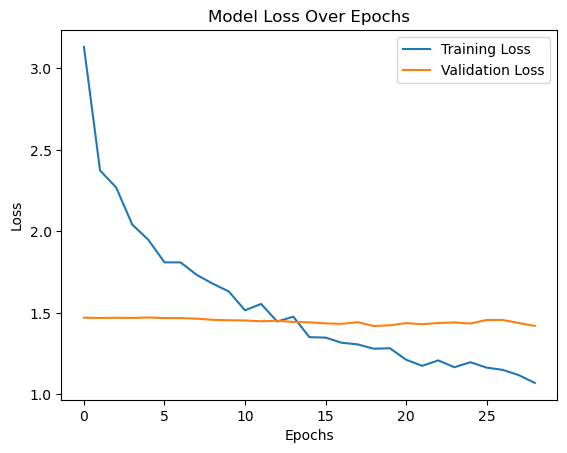

In [16]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 1.Random Search 

### Two Layers (Model 3)

In [19]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.5597392320632935
Final Validation Loss: 1.6334689855575562
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.0705389976501465
Final Validation Loss: 2.085648536682129
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.2784720659255981
Final Validation Loss: 1.3736423254013062
Running combination 4

In [20]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 2.7502 - val_loss: 1.3703
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0192 - val_loss: 1.3694
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7817 - val_loss: 1.3699
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8074 - val_loss: 1.3747
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6046 - val_loss: 1.3705
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6467 - val_loss: 1.3674
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4138 - val_loss: 1.3635
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3351 - val_loss: 1.3573
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2541 - val_loss: 1.3562
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2327 - val_loss: 1.3431
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2408 - val_loss: 1.3438
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.02012867767239423
Test RMSE: 0.022446093662589383
Training MAE: 0.01442107206007395
Test MAE: 0.016954641092998057
Directional Accuracy on Training Data: 62.801377726750864%
Directional Accuracy on Test Data: 59.333333333333336%


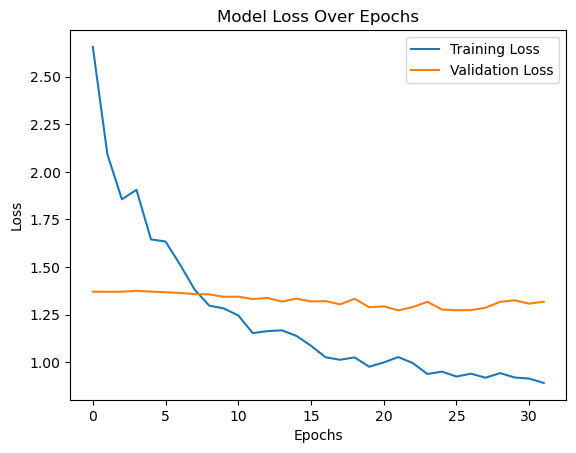

In [21]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 4)

In [23]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0391889810562134
Final Validation Loss: 1.4100106954574585
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.093729496002197
Final Validation Loss: 3.979959487915039
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.6570730209350586
Final Valida

In [24]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - loss: 2.8816 - val_loss: 1.2623
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.1265 - val_loss: 1.2615
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.1041 - val_loss: 1.2608
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7166 - val_loss: 1.2599
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.9041 - val_loss: 1.2604
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6197 - val_loss: 1.2601
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7041 - val_loss: 1.2595
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6727 - val_loss: 1.2605
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6655 - val_loss: 1.2619
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6278 - val_loss: 1.2609
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.5656 - val_loss: 1.2630
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.5581 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.019353555449133083
Test RMSE: 0.02264348179826494
Training MAE: 0.013940608013415245
Test MAE: 0.01749623625347844
Directional Accuracy on Training Data: 59.127439724454646%
Directional Accuracy on Test Data: 50.66666666666667%


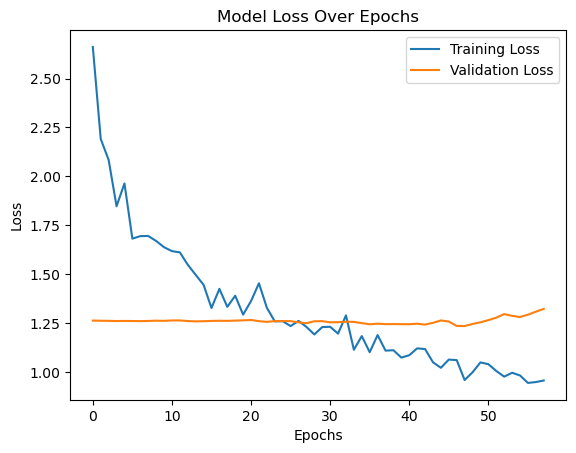

In [25]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 5) 

In [27]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 15:00:59,669] A new study created in memory with name: no-name-794ed8ac-68d6-4dfe-9ed0-bda0cd9b71cf
[I 2024-11-13 15:01:19,373] Trial 0 finished with value: 1.6123017072677612 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.6123017072677612.
[I 2024-11-13 15:01:39,131] Trial 1 finished with value: 3.799720525741577 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.6123017072677612.
[I 2024-11-13 15:02:36,053] Trial 2 finished with value: 4.23798942565918 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2,

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.2, 'l2_lambda': 0.002683355490924503, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 150, 'batch_size': 120}
Best validation loss: 1.081648588180542


In [28]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.002714142252080901,
    'epochs': 150,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 2.0151 - val_loss: 1.0930
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4633 - val_loss: 1.0872
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4304 - val_loss: 1.0873
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4549 - val_loss: 1.0884
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2342 - val_loss: 1.0894
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3299 - val_loss: 1.0877
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3424 - val_loss: 1.0870
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1351 - val_loss: 1.0870
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1520 - val_loss: 1.0873
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1349 - val_loss: 1.0866
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1755 - val_loss: 1.0859
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2017 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.020256662695521177
Test RMSE: 0.022985132425084587
Training MAE: 0.014630598239662734
Test MAE: 0.017508577913325375
Directional Accuracy on Training Data: 57.97933409873708%
Directional Accuracy on Test Data: 53.333333333333336%


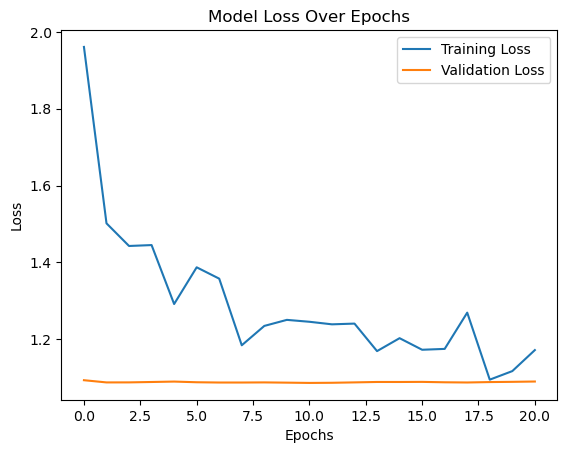

In [29]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 6) 

In [31]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 50s]
val_loss: 1.2762640714645386

Best val_loss So Far: 1.2692660093307495
Total elapsed time: 00h 22m 15s
Built model with params: dropout_rate=0.2, recurrent_dropout=0.1, l2_lambda=0.0848820698329123, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=3, batch_size=32
Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0848820698329123, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'batch_size': 32}
Best batch size: 32


In [32]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.0218590046119431,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - loss: 6.6559 - val_loss: 3.5818
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.7364 - val_loss: 3.5286
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4917 - val_loss: 3.4676
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7780 - val_loss: 3.4028
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.4621 - val_loss: 3.3370
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1782 - val_loss: 3.2665
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.2075 - val_loss: 3.1956
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2085 - val_loss: 3.1247
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.7318 - val_loss: 3.0576
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6186 - val_loss: 2.9898
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3702 - val_loss: 2.9092
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/st

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.020379266382095453
Test RMSE: 0.023003432981341804
Training MAE: 0.014780027591528097
Test MAE: 0.01739230298219025
Directional Accuracy on Training Data: 54.30539609644087%
Directional Accuracy on Test Data: 52.666666666666664%


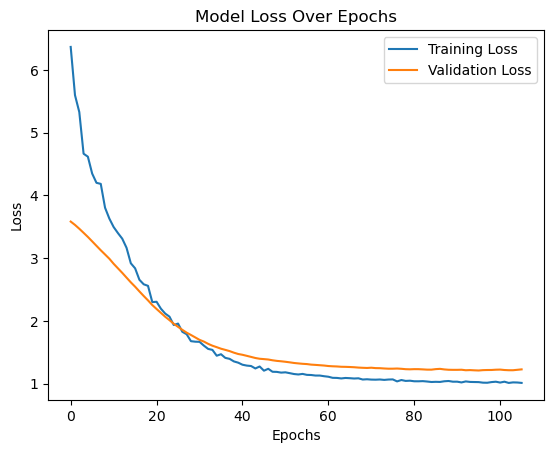

In [33]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation 

| Model | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) | 
|-------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| 1     | 0.02027       | 0.02308    | 0.01468       | 0.01751   | 52.7%                        | 50.0%                       | 
| 2     | 0.01977       | 0.02305    | 0.01443       | 0.01741   | 59.4%                        | 54.0%                       |
| 3     | 0.020329       | 0.023003    | 0.01465       | 0.017431   | 51.8%                        | 46.0%                       |
| 4     | 0.018829       | 0.022622    | 0.013655       | 0.01727   | 59.7%                        | 52.0%                       |
| 5     | 0.020185       | 0.022906    | 0.014546       | 0.017450   | 59.6%                        | **60.7%**                   |
| 6     | 0.019987       | 0.023032    | 0.014552       | 0.017620   | 52.81%                        | 56.0%                       |


## Sequence Length = 12 

In [37]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 12  # Number of time steps used for target prediction, 12 weeks (Quarterly).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (864, 12, 5)
Reshaped y_train_seq shape: (864, 1)
Reshaped X_test_seq shape: (143, 12, 5)
Reshaped  y_test_seq shape: (143, 1)


### 1. Random Search (Two Layers - Model 1)

In [39]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.6819857358932495
Final Validation Loss: 1.7873555421829224
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.8224691152572632
Final Validation Loss: 1.943240761756897
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.68576979637146
Final Validation Loss: 1.4648078680038452
Running combination 4/3

In [40]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 2.9048 - val_loss: 1.3624
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.2604 - val_loss: 1.3519
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.0951 - val_loss: 1.3511
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.9211 - val_loss: 1.3638
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.9609 - val_loss: 1.3514
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.6636 - val_loss: 1.3657
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5191 - val_loss: 1.3620
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.4354 - val_loss: 1.3926
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3576 - val_loss: 1.4253
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2586 - val_loss: 1.4349
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2539 - val_loss: 1.4581
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
LSTM Model Performance:
Training RMSE: 0.020357127506700903
Test RMSE: 0.02325925285651794
Training MAE: 0.014789920143340421
Test MAE: 0.01750357407783943
Directional Accuracy on Training Data: 56.89455388180765%
Directional Accuracy on Test Data: 61.267605633802816%


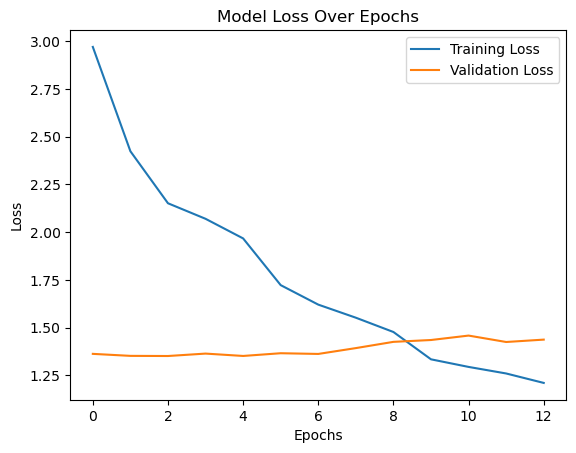

In [41]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [43]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.097215175628662
Final Validation Loss: 1.6395092010498047
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.121798038482666
Final Validation Loss: 4.114628791809082
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.1874756813049316
Final Validat

In [44]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 477ms/step - loss: 4.3032 - val_loss: 1.5036
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 3.8222 - val_loss: 1.5033
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 3.2621 - val_loss: 1.5031
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 3.1221 - val_loss: 1.5034
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 2.9142 - val_loss: 1.5049
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 2.8689 - val_loss: 1.5051
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 3.0381 - val_loss: 1.5043
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 2.7735 - val_loss: 1.5025
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 2.5535 - val_loss: 1.5003
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 2.4333 - val_loss: 1.4980
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.5733 - val_loss: 1.4991
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 2.3880 - val_l

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
LSTM Model Performance:
Training RMSE: 0.02037519351824219
Test RMSE: 0.023215353166886183
Training MAE: 0.014704014462101818
Test MAE: 0.017427787383001613
Directional Accuracy on Training Data: 49.362688296639625%
Directional Accuracy on Test Data: 51.40845070422535%


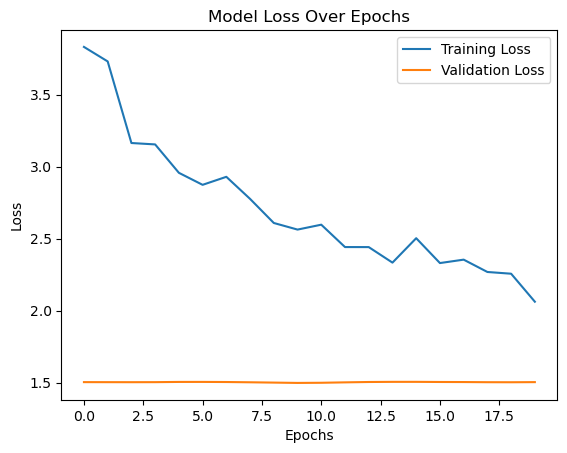

In [45]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [47]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 15:56:55,726] A new study created in memory with name: no-name-ff174d5d-984e-4aed-b1ba-6af0b08cd6b7
[I 2024-11-13 15:57:17,507] Trial 0 finished with value: 1.6623047590255737 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.6623047590255737.
[I 2024-11-13 15:57:42,442] Trial 1 finished with value: 3.836202383041382 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.6623047590255737.
[I 2024-11-13 15:59:15,293] Trial 2 finished with value: 4.316595077514648 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0012015897667654984, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 100, 'batch_size': 120}
Best validation loss: 1.0932625532150269


In [48]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0012240775718069888,
    'epochs': 150,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 2.0877 - val_loss: 1.0938
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7099 - val_loss: 1.0927
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7313 - val_loss: 1.1022
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6051 - val_loss: 1.1094
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3878 - val_loss: 1.1041
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5193 - val_loss: 1.1027
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3281 - val_loss: 1.1098
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5678 - val_loss: 1.1187
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2506 - val_loss: 1.1205
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.3733 - val_loss: 1.1150
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2995 - val_loss: 1.1110
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2939 - val_l

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step
LSTM Model Performance:
Training RMSE: 0.020418635856111814
Test RMSE: 0.0231531763453161
Training MAE: 0.014849000772928835
Test MAE: 0.017508650940738182
Directional Accuracy on Training Data: 43.56894553881808%
Directional Accuracy on Test Data: 51.40845070422535%


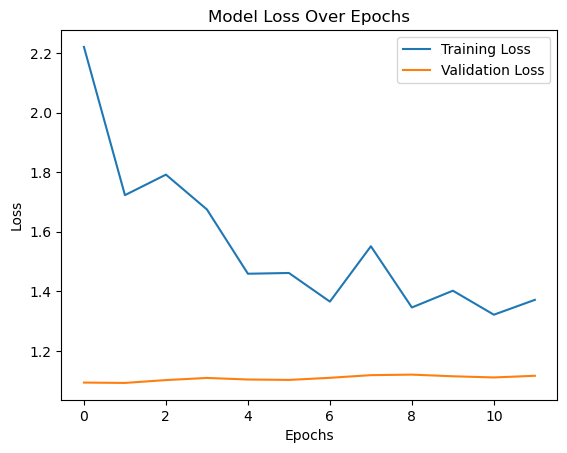

In [49]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [51]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 19s]
val_loss: 1.29628586769104

Best val_loss So Far: 1.29628586769104
Total elapsed time: 00h 20m 21s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0026041400819170504, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0026041400819170504, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size: 256


In [52]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model
    
# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.0072 - val_loss: 1.2779
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7239 - val_loss: 1.2805
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5125 - val_loss: 1.2810
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5061 - val_loss: 1.2821
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3217 - val_loss: 1.2870
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2999 - val_loss: 1.2916
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2852 - val_loss: 1.2967
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1987 - val_loss: 1.2985
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2089 - val_loss: 1.3058
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1576 - val_loss: 1.3183
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1142 - val_loss: 1.3333
Final Training Loss: 1.1811045408248901
Final Validation Loss:

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
LSTM Model Performance:
Training RMSE: 0.02044933129757567
Test RMSE: 0.023170637439472768
Training MAE: 0.014849632026679683
Test MAE: 0.017517225795207675
Directional Accuracy on Training Data: 42.64194669756663%
Directional Accuracy on Test Data: 52.816901408450704%


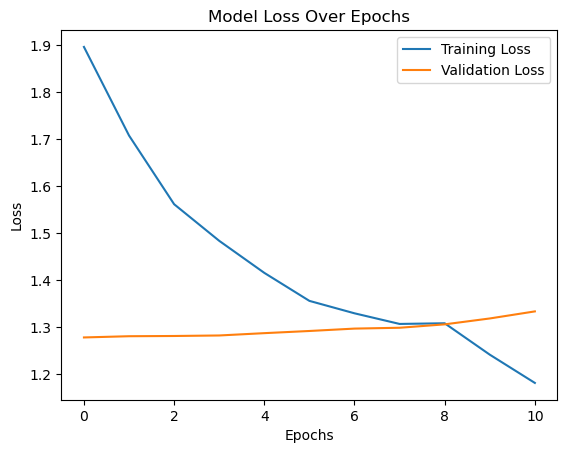

In [53]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

| Model | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) | 
|-------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| 1     | 0.02027       | 0.02308    | 0.01468       | 0.01751   | 52.7%                        | 50.0%                       | 
| 2     | 0.01977       | 0.02305    | 0.01443       | 0.01741   | 59.4%                        | 54.0%                       |
| 3     | 0.020329       | 0.023003    | 0.01465       | 0.017431   | 51.8%                        | 46.0%                       |
| 4     | 0.018829       | 0.022622    | 0.013655       | 0.01727   | 59.7%                        | 52.0%                       |

## Sequence Length = 26 

In [57]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 26  # Number of time steps used for target prediction, 26 weeks (Six-Months).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (850, 26, 5)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 5)
Reshaped  y_test_seq shape: (129, 1)


### 1. Random Search (Two Layers - Model 1)

In [59]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.08440101146698
Final Validation Loss: 1.333011507987976
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.9566689729690552
Final Validation Loss: 1.914771318435669
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.417626976966858
Final Validation Loss: 1.1555172204971313
Running combination 4/30:

In [60]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 3.1051 - val_loss: 1.2331
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.3236 - val_loss: 1.2307
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.1987 - val_loss: 1.2464
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.0339 - val_loss: 1.2551
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.8978 - val_loss: 1.2609
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.5713 - val_loss: 1.2737
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.4388 - val_loss: 1.2891
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.5232 - val_loss: 1.2973
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.3555 - val_loss: 1.3090
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.3432 - val_loss: 1.2352
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.2015 - val_loss: 1.2545
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/ste

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM Model Performance:
Training RMSE: 0.020502456625237
Test RMSE: 0.024230416608325388
Training MAE: 0.014837506090691146
Test MAE: 0.018342744173208143
Directional Accuracy on Training Data: 56.65488810365136%
Directional Accuracy on Test Data: 57.03125%


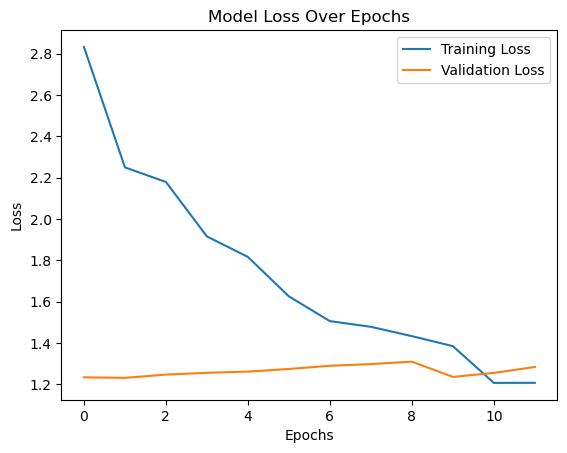

In [61]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [63]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0254290103912354
Final Validation Loss: 1.4330687522888184
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.140512466430664
Final Validation Loss: 4.019299507141113
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.6258623600006104
Final Valida

In [64]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
        
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - loss: 3.1402 - val_loss: 1.2735
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 2.2820 - val_loss: 1.2668
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 2.2671 - val_loss: 1.2600
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 1.9645 - val_loss: 1.2617
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 1.9040 - val_loss: 1.2776
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 1.7372 - val_loss: 1.2740
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 1.7018 - val_loss: 1.2745
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 1.9008 - val_loss: 1.3094
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 1.6994 - val_loss: 1.3156
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 1.7614 - val_loss: 1.3016
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 1.5000 - val_loss: 1.2623
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
LSTM Model Performance:
Training RMSE: 0.020469690687669805
Test RMSE: 0.024201428842022435
Training MAE: 0.014876317736112116
Test MAE: 0.018582195573136312
Directional Accuracy on Training Data: 51.47232037691401%
Directional Accuracy on Test Data: 52.34375%


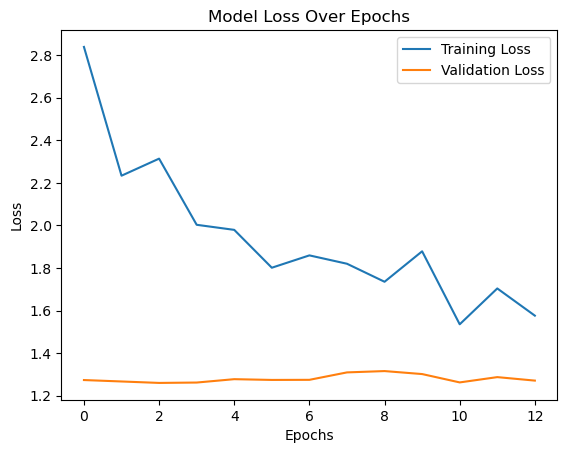

In [65]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [67]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 16:59:06,884] A new study created in memory with name: no-name-5821cb99-b769-460e-b735-05f89320d2be
[I 2024-11-13 16:59:34,262] Trial 0 finished with value: 1.4006462097167969 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.4006462097167969.
[I 2024-11-13 17:00:01,595] Trial 1 finished with value: 3.9783754348754883 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.4006462097167969.
[I 2024-11-13 17:02:15,458] Trial 2 finished with value: 4.7478485107421875 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0011454828358668492, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 64}
Best validation loss: 0.9259576797485352


In [68]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0011554791595316783,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 1.6319 - val_loss: 0.9891
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.4455 - val_loss: 0.9859
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.4501 - val_loss: 0.9792
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.2986 - val_loss: 0.9789
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.2918 - val_loss: 0.9790
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1666 - val_loss: 0.9692
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1668 - val_loss: 0.9810
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.1635 - val_loss: 0.9642
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1622 - val_loss: 0.9735
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.1406 - val_loss: 0.9756
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.1459 - val_loss: 0.9797
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM Model Performance:
Training RMSE: 0.020349529285585463
Test RMSE: 0.02402667983244847
Training MAE: 0.01465896646467044
Test MAE: 0.01820359895078489
Directional Accuracy on Training Data: 67.60895170789163%
Directional Accuracy on Test Data: 64.84375%


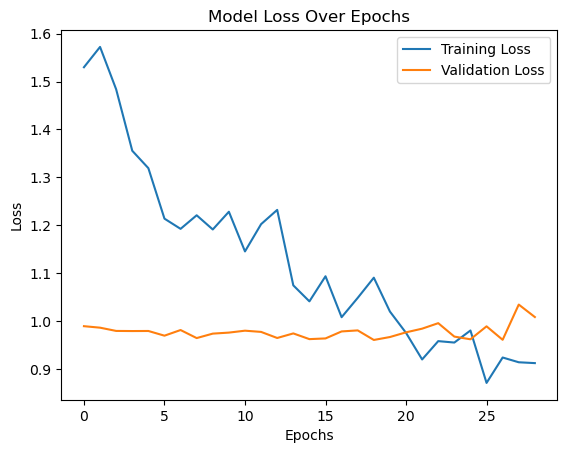

In [69]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [71]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 36s]
val_loss: 1.5710058212280273

Best val_loss So Far: 1.154745101928711
Total elapsed time: 00h 39m 05s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0026041400819170504, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0026041400819170504, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size: 256


In [72]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 00.0029343923926946802,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 1.7557 - val_loss: 1.2317
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.6270 - val_loss: 1.2100
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.5710 - val_loss: 1.2075
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3728 - val_loss: 1.1873
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3494 - val_loss: 1.1951
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.4039 - val_loss: 1.2023
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.3702 - val_loss: 1.2048
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3181 - val_loss: 1.1974
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.2909 - val_loss: 1.2179
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3264 - val_loss: 1.2100
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.2236 - val_loss: 1.2095
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.2004 - val_l

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM Model Performance:
Training RMSE: 0.02044607918417583
Test RMSE: 0.0245408746987349
Training MAE: 0.014811629842476245
Test MAE: 0.018974918848679214
Directional Accuracy on Training Data: 59.95288574793876%
Directional Accuracy on Test Data: 62.5%


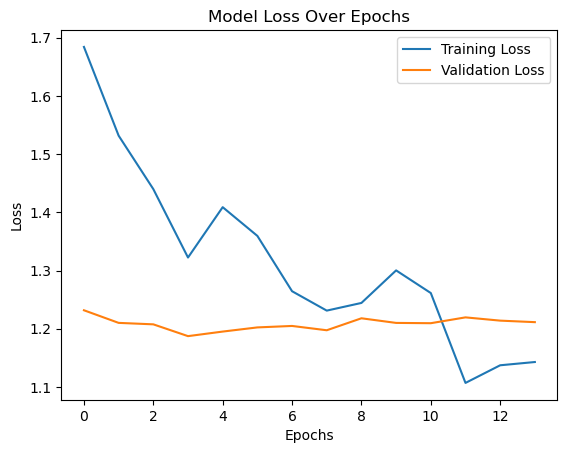

In [73]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

| Model | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) | 
|-------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| 1     | 0.02027       | 0.02308    | 0.01468       | 0.01751   | 52.7%                        | 50.0%                       | 
| 2     | 0.01977       | 0.02305    | 0.01443       | 0.01741   | 59.4%                        | 54.0%                       |
| 3     | 0.020329       | 0.023003    | 0.01465       | 0.017431   | 51.8%                        | 46.0%                       |
| 4     | 0.018829       | 0.022622    | 0.013655       | 0.01727   | 59.7%                        | 52.0%                       |

## Sequence Length = 52

In [77]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 52  # Number of time steps used for target prediction, 52 weeks (One year).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (824, 52, 5)
Reshaped y_train_seq shape: (824, 1)
Reshaped X_test_seq shape: (103, 52, 5)
Reshaped  y_test_seq shape: (103, 1)


### 1. Random Search (Two Layers - Model 1)

In [79]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.827374815940857
Final Validation Loss: 1.913159966468811
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.387868642807007
Final Validation Loss: 2.4169936180114746
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.6863856315612793
Final Validation Loss: 1.6620391607284546
Running combination 4/3

In [80]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - loss: 3.1337 - val_loss: 1.5933
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 2.8316 - val_loss: 1.5908
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 2.1631 - val_loss: 1.5929
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 2.0924 - val_loss: 1.5947
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 2.2323 - val_loss: 1.5880
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 1.9563 - val_loss: 1.5791
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 2.0527 - val_loss: 1.5853
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 1.7612 - val_loss: 1.5741
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 1.8068 - val_loss: 1.5764
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 1.6509 - val_loss: 1.5737
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 1.6012 - val_loss: 1.5837
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM Model Performance:
Training RMSE: 0.02044323666418032
Test RMSE: 0.025435926144176522
Training MAE: 0.014981374062431635
Test MAE: 0.020283158408491573
Directional Accuracy on Training Data: 64.27703523693803%
Directional Accuracy on Test Data: 54.90196078431373%


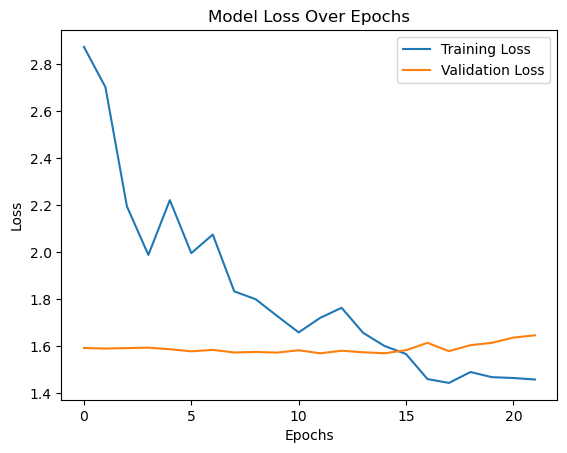

In [81]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [83]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0516377687454224
Final Validation Loss: 1.5555119514465332
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.183912754058838
Final Validation Loss: 4.299307823181152
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.960617780685425
Final Validat

In [84]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 598ms/step - loss: 2.3759 - val_loss: 1.7324
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - loss: 2.0617 - val_loss: 1.7323
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 1.9692 - val_loss: 1.7343
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 1.6880 - val_loss: 1.7329
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - loss: 1.8185 - val_loss: 1.7306
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 1.5658 - val_loss: 1.7275
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 1.5223 - val_loss: 1.7256
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - loss: 1.6478 - val_loss: 1.7254
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 1.6095 - val_loss: 1.7228
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 1.4729 - val_loss: 1.7219
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 1.4866 - val_loss: 1.7255
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 1.

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM Model Performance:
Training RMSE: 0.02057389615237075
Test RMSE: 0.025497763033120617
Training MAE: 0.015055841282072737
Test MAE: 0.020056271322984716
Directional Accuracy on Training Data: 57.35115431348724%
Directional Accuracy on Test Data: 54.90196078431373%


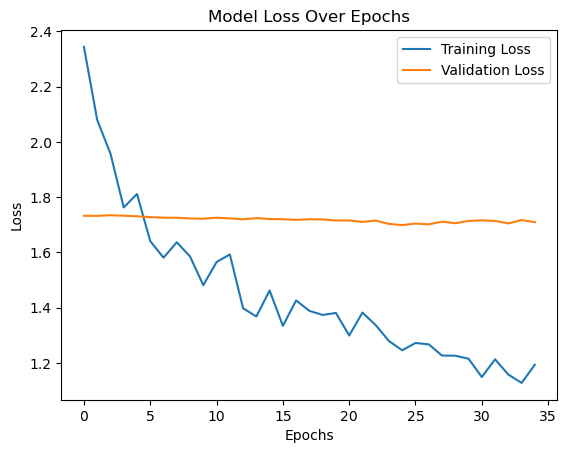

In [85]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [87]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.
    
    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 18:36:10,488] A new study created in memory with name: no-name-a1322880-430e-42fa-b9b2-7152897dc7a2
[I 2024-11-13 18:36:41,636] Trial 0 finished with value: 1.8467261791229248 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.8467261791229248.
[I 2024-11-13 18:37:20,929] Trial 1 finished with value: 4.110915184020996 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.8467261791229248.
[I 2024-11-13 18:42:27,231] Trial 2 finished with value: 5.081692218780518 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0019223481607694784, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 150, 'batch_size': 64}
Best validation loss: 1.3782212734222412


In [88]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010171855559193877,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Select the loss function based on tuning results.
    if params['loss_function'] == 'huber_loss':
        loss = Huber()  # Huber loss is more robust to outliers
    else:
        loss = MeanSquaredError()  # Use MSE as default loss function for regression
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 1.5701 - val_loss: 1.4159
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.6135 - val_loss: 1.4236
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.4981 - val_loss: 1.4251
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.5903 - val_loss: 1.4306
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.3325 - val_loss: 1.4238
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.2111 - val_loss: 1.4209
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.2587 - val_loss: 1.4151
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.2033 - val_loss: 1.4249
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.2620 - val_loss: 1.4194
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1.1975 - val_loss: 1.4173
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.2200 - val_loss: 1.4144
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/ste

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM Model Performance:
Training RMSE: 0.020049981538564344
Test RMSE: 0.025127608901522606
Training MAE: 0.014824684355424552
Test MAE: 0.01977663360602937
Directional Accuracy on Training Data: 69.01579586877278%
Directional Accuracy on Test Data: 64.70588235294117%


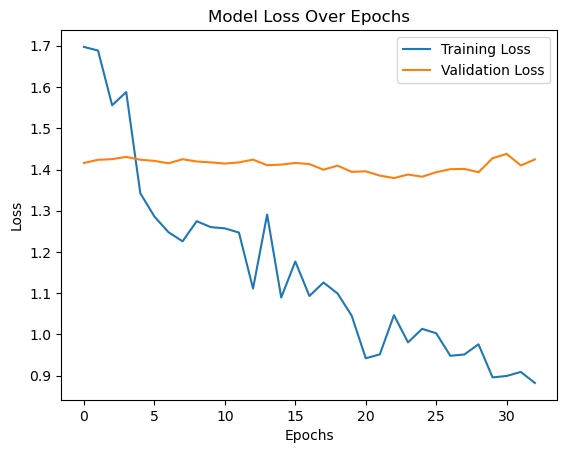

In [89]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [91]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 01m 18s]
val_loss: 1.7997627258300781

Best val_loss So Far: 1.374737024307251
Total elapsed time: 01h 08m 37s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.025064206402151706, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=3, batch_size=120
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.025064206402151706, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'batch_size': 120}
Best batch size: 120


In [92]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0026041400819170504,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - loss: 2.7562 - val_loss: 1.6312
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 2.5618 - val_loss: 1.6229
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 2.2846 - val_loss: 1.6275
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 2.2035 - val_loss: 1.6240
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 2.2697 - val_loss: 1.6281
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 2.1251 - val_loss: 1.6269
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 1.9541 - val_loss: 1.6241
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 1.9510 - val_loss: 1.6238
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 2.0711 - val_loss: 1.6267
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 1.7747 - val_loss: 1.6252
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 1.8406 - val_loss: 1.6268
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 1.8

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM Model Performance:
Training RMSE: 0.020658738885961255
Test RMSE: 0.025627350766865346
Training MAE: 0.014902039127366111
Test MAE: 0.019930297558001322
Directional Accuracy on Training Data: 55.1640340218712%
Directional Accuracy on Test Data: 62.745098039215684%


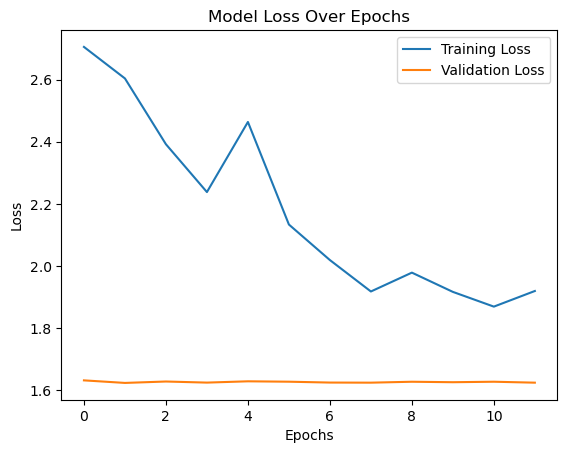

In [93]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

| Model | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) | 
|-------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| 1     | 0.02027       | 0.02308    | 0.01468       | 0.01751   | 52.7%                        | 50.0%                       | 
| 2     | 0.01977       | 0.02305    | 0.01443       | 0.01741   | 59.4%                        | 54.0%                       |
| 3     | 0.020329       | 0.023003    | 0.01465       | 0.017431   | 51.8%                        | 46.0%                       |
| 4     | 0.018829       | 0.022622    | 0.013655       | 0.01727   | 59.7%                        | 52.0%                       |